# Figures for 2019 ADAP Proposal

* Magnitude-surface brightness with notable large galaxies labeled
* Show color-magnitude space with Tractor mag/color and custom (aperture) mag/color.
* Need for this analysis:
  - Where does the Tractor pipeline break down?
  - Which galaxies require custom analysis?

In [1]:
import os, warnings, pdb
from glob import glob
import numpy as np
import numpy.ma as ma
import pandas as pd
from astrometry.util.fits import fits_table

import fitsio
from astropy.table import Table, Column, vstack, hstack

In [2]:
import corner
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import LSLGA.io
import LSLGA.NLSA
import LSLGA.qa
import LSLGA.ellipse

In [4]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.8, palette='Set2')
%matplotlib inline

In [5]:
LSLGAdir = os.getenv('LSLGA_DIR')
#adapdir = os.path.join(os.getenv('HOME'), 'repos', 'papers', 'grants', 'nasa-adap-2019')
adapdir = os.path.join(LSLGAdir, 'science', 'proposals', 'nasa-adap-2019')

In [6]:
PIXSCALE = 0.262

In [7]:
seed = 1
rand = np.random.RandomState(seed)

### Ellipse-fitting NGC5322

In [17]:
tt = Table.read('/Users/ioannis/research/projects/LSLGA/NLSA/8/1/184/NGC5322/NGC5322-tractor.fits')
tt = tt[np.argsort(tt['shapedev_r'])[::-1]][0]
cols = ['ra', 'dec', 'type', 'shapedev_r',]
cols += ['flux_{}'.format(bb) for bb in ('g', 'r', 'z', 'w1', 'w2', 'w3', 'w4')]
cols += ['flux_ivar_{}'.format(bb) for bb in ('g', 'r', 'z', 'w1', 'w2', 'w3', 'w4')]
tt[cols]

ra,dec,type,shapedev_r,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4
deg,deg,,arcsec,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2,1/nanomaggy^2
float64,float64,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
207.31360766282367,60.19054459091414,DEV,35.963028,51032.92,108675.04,173005.16,126294.73,67562.625,34738.555,32283.23,0.060252897,0.019527867,0.011034269,0.1742277,0.03782868,0.000105459614,2.8181848e-06


In [ ]:
bands = ('FUV', 'NUV', 'g', 'r', 'z', 'W1', 'W2', 'W3', 'W4')
onegal = LSLGA.NLSA.read_nlsa_parent(montage=True, first=1, last=1)[0]
galaxy, galaxydir = LSLGA.NLSA.get_galaxy_galaxydir(onegal)
#%time LSLGA.ellipse.LSLGA_ellipse(onegal, galaxy=gal, galaxydir=galdir, 
#                                  maxsma=1500, verbose=True, nproc=4)
data = LSLGA.io.read_multiband(galaxy, galaxydir, band=bands)

In [ ]:
#pixscale, wise_pixscale = 2.75, galex_pixscale = 1.5
pixscale = 0.262
filt2pixscalefactor = {'g': 1.0, 'r': 1.0, 'z': 1.0, 'g_pixscale': pixscale,
                       'r_pixscale': pixscale, 'z_pixscale': pixscale}
factor = pixscale / data['galex_pixscale']
filt2pixscalefactor.update({'FUV': factor, 'NUV': factor, 'FUV_pixscale': data['galex_pixscale'],
                            'NUV_pixscale': data['galex_pixscale']})
        
factor = pixscale / data['unwise_pixscale']
filt2pixscalefactor.update({'W1': factor, 'W2': factor, 'W3': factor, 'W4': factor,
                            'W1_pixscale': data['unwise_pixscale'], 'W2_pixscale': data['unwise_pixscale'],
                            'W3_pixscale': data['unwise_pixscale'], 'W4_pixscale': data['unwise_pixscale']})

In [ ]:
phot = []
radius = 1400 # [grz pixels]
for filt in bands:
    pixscale = filt2pixscalefactor['{}_pixscale'.format(filt)]
    pixscalefactor = filt2pixscalefactor[filt]
    img = ma.getdata(data['{}_masked'.format(filt)]) # [nanomaggies/arcsec2]
    mask = ma.getmask(data['{}_masked'.format(filt)])
    x0, y0 = np.array(img.shape) // 2 * pixscalefactor
    rad = radius * pixscalefactor
    print(filt, img.shape, x0, y0, rad)
    phot1 = LSLGA.ellipse.apphot_one(img, mask, 0.0, x0, y0, rad, rad, pixscale)
    phot.append(phot1)

In [ ]:
phot

In [ ]:
stop

In [ ]:
plt.imshow(np.log10(data['W4']), origin='lower')

In [ ]:
ell = LSLGA.io.read_ellipsefit(gal, galdir, verbose=True)
pngfile = os.path.join(adapdir, 'ngc5322-sbprofile.png')
LSLGA.qa.display_ellipse_sbprofile(ell, png=pngfile, verbose=True)
pngfile = os.path.join(adapdir, 'ngc5322-cog.png')
LSLGA.qa_curveofgrowth(ell, png=pngfile, verbose=True)

### Read dr8 catalogs.

In [8]:
lslga = LSLGA.io.read_parent(verbose=True)
lslga[:3]

Read galaxy indices 0 through 532706 (N=532707) from /Users/ioannis/research/projects/LSLGA/sample/v2.0/LSLGA-v2.0.fits


LSLGA_ID,GALAXY,PGC,RA,DEC,TYPE,BAR,RING,MULTIPLE,COMPACTNESS,T,PA,D25,BA,DIAM_REF,Z,SB_D25,MAG,MAG_REF,WISE_RA,WISE_DEC,CNTR,W1MPRO,W1SIGMPRO,W2MPRO,W2SIGMPRO,W3MPRO,W3SIGMPRO,W4MPRO,W4SIGMPRO,RCHI2,CC_FLAGS,EXT_FLG,PH_QUAL,XSCPROX,W1RSEMI,W1BA,W1PA,W1GMAG,W1GERR,W2GMAG,W2GERR,W3GMAG,W3GERR,W4GMAG,W4GERR,IN_ALLWISE,IN_DESI,NEAR_BRIGHTSTAR
int64,bytes29,int64,float64,float64,bytes4,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,bytes3,float32,float32,float32,bytes1,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,bytes4,int32,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool
2,PGC1283207,1283207,228.3770865,5.4232017,S?,nan,nan,nan,nan,0.9,152.2,0.36307806,0.724436,iso,0.03463229,23.40448,16.976,B,228.3771822,5.4228275,2278106001351000050,13.453,0.039,13.393,0.045,11.785,0.242,8.741,nan,1.088,0000,4,AABU,0.95,9.75,0.73,-25.0,13.27,0.01,13.334,0.02,12.209,0.183,10.103,0.835,True,True,False
3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,nan,nan,M,nan,4.7,159.26,0.4017908,0.7816278,iso,0.073888786,23.498482,16.85,B,202.5444539,6.9345167,2028107501351007858,13.282,0.025,13.109,0.028,9.197,0.03,7.024,0.098,2.075,0000,5,AAAA,0.51,9.36,0.79,-10.0,13.214,0.01,13.069,0.021,9.695,0.024,7.485,0.104,True,True,False
4,SDSSJ145059.93+135143.0,4435547,222.749787,13.8619111,S?,nan,nan,nan,nan,5.0,44.57,0.33342642,0.6637431,iso,0.07567602,24.457481,18.214,B,222.7496762,13.8620163,2234113601351039304,14.829,0.029,14.596,0.049,11.637,0.165,8.57,nan,1.155,0000,0,AABU,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,True,False


In [9]:
#cat = LSLGA.NLSA.read_nlsa_parent()
camera = '90prime-mosaic'
samplefile = os.path.join(LSLGA.NLSA.sample_dir(), 'NLSA-{}-v1.2.fits'.format(camera))
cat = Table(fitsio.read(samplefile, lower=True))
cat

galaxy,brickname,objid,ra,dec,ra_lslga,dec_lslga,maskbits,allmask_g,allmask_r,allmask_z,fracdev,rmag,gr,rz,sb,reff,ref_cat,type,morphtype,ref_id
bytes29,bytes8,int32,float64,float64,float64,float64,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,bytes2,bytes4,bytes4,int64
,1826p447,224,182.68180460717596,44.63971416264253,0.0,0.0,0,0,0,0,0.0,19.526407,1.0528812,0.6700516,22.055576,1.2786272,,EXP,,0
,1826p447,323,182.734087145654,44.64727891648112,0.0,0.0,0,0,0,0,1.0,19.876667,1.24893,0.6837368,20.49625,0.5306726,,DEV,,0
,1826p447,388,182.5347838907106,44.65183287316244,0.0,0.0,0,0,0,0,1.0,18.895191,-0.10537338,-0.29808426,21.516804,1.3342359,G2,DEV,,1539272676378802432
,1826p447,421,182.63389945179645,44.654964438288786,0.0,0.0,0,0,0,0,0.0,19.70515,1.373642,0.9698944,23.139236,1.9396666,,EXP,,0
,1826p447,445,182.52785883557556,44.65559691243577,0.0,0.0,0,0,0,0,1.0,19.824081,1.5297871,0.9595909,22.241543,1.2145139,,DEV,,0
,1826p447,470,182.5042161324661,44.660632361743346,0.0,0.0,0,0,0,0,0.0,16.95381,0.40322495,0.23479843,21.177313,2.7900417,,EXP,,0
,1826p447,514,182.7334743956679,44.66164929056454,0.0,0.0,0,0,0,0,0.0,18.662315,1.3109436,0.7883339,21.809208,1.6993719,,EXP,,0
,1826p447,526,182.55887930139295,44.66679261216065,0.0,0.0,0,0,0,0,0.0,17.904219,0.29933357,0.21159935,22.262344,2.9684887,,EXP,,0
,1826p447,533,182.56028446202632,44.66579674443126,0.0,0.0,0,0,0,0,1.0,16.442135,0.34840393,0.065467834,20.832365,3.0127015,G2,DEV,,1539272749393691136


In [10]:
cat[cat['ref_cat'] == 'L2']

galaxy,brickname,objid,ra,dec,ra_lslga,dec_lslga,maskbits,allmask_g,allmask_r,allmask_z,fracdev,rmag,gr,rz,sb,reff,ref_cat,type,morphtype,ref_id
bytes29,bytes8,int32,float64,float64,float64,float64,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,bytes2,bytes4,bytes4,int64
SDSSJ120927.91+435722.5,1822p440,1233,182.36628148141847,43.956256555462055,182.366379,43.956309600000004,4096,0,0,0,0.0,17.233551,0.6373787,0.44517326,22.043474,3.6550612,L2,EXP,S?,654665
NGC4135,1822p440,1827,182.2866169251734,44.003191263865226,182.2867335,44.0031946,4096,0,0,0,0.04330812,13.748771,0.64966965,0.4590788,20.53558,9.083896,L2,COMP,SABb,116802
PGC038629,1822p440,2799,182.3589707162256,44.07326780220273,182.3589705,44.0732974,4096,0,0,0,1.0,14.6043415,0.6699505,0.50763226,21.312721,8.761653,L2,DEV,SBbc,257685
NGC4137,1822p440,2971,182.323070962058,44.090236951213654,182.32288649999998,44.0901584,4096,0,0,0,0.0,14.1009245,0.5168333,0.34761906,21.526741,12.191956,L2,EXP,Sc,375848
PGC200283,1822p440,2972,182.3100699252788,44.09054763432598,182.3100135,44.090561,4096,0,0,0,0.36574298,16.699375,0.60277176,0.4132309,21.894644,4.364794,L2,COMP,Sd,202901
SDSSJ121218.24+440909.7,1829p442,418,183.07594396972334,44.1526826361592,183.075966,44.152655700000004,4096,0,0,0,1.0,16.196342,0.5552025,0.40236855,25.031927,23.336037,L2,DEV,S?,373278
SDSSJ121222.29+441644.8,1829p442,2329,183.09274253146683,44.279123220400315,183.09286799999998,44.27908370000001,4096,0,0,0,0.0,16.515266,0.4893837,0.26633453,23.10031,8.277871,L2,EXP,SBcd,16220
2MASXJ12114074+4418035,1829p442,2607,182.91973209288898,44.30105597185797,182.9197965,44.301066600000006,4096,0,0,0,1.0,17.221844,1.1120262,0.80763245,21.274532,2.5789797,L2,DEV,nan,1085697
2MASXJ12122639+4421047,1829p442,3211,183.11005362431263,44.35116071625915,183.110091,44.351208299999996,4096,0,0,0,1.0,16.523638,1.0666485,0.7393007,20.445122,2.4277666,L2,DEV,E,844323


In [11]:
ww = np.where(['NGC' in gg or 'UGC' in gg for gg in cat['galaxy']])[0]
#cat[ww]

Choosing a random subset of galaxies!


array([18.966854, 19.673931, 19.804016, 20.31988 , 20.330528, 20.438385,
       20.449326, 20.503342, 20.53558 , 20.556389, 21.19166 , 21.30481 ,
       21.781164, 21.834414, 21.873726, 22.072304, 22.485153, 22.576626,
       22.92656 , 23.009998, 23.210407, 23.290321, 23.6867  , 23.710928,
       23.743595, 23.8909  , 23.928104, 24.07245 , 24.496325, 25.71668 ,
       25.81657 , 26.008656, 26.1675  , 26.582638, 26.594555],
      dtype=float32)

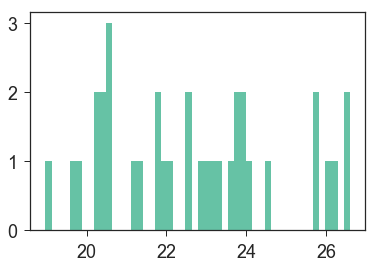

In [12]:
ss = LSLGA.NLSA.read_nlsa_parent(proposal=True)
_ = plt.hist(ss['SB'], bins=50)
ss['SB'].data

In [ ]:
def ngc3938_ccdpos():
    from astrometry.util.fits import fits_table
    from legacypipe.survey import LegacySurveyData
    def get_ccds():
        survey = LegacySurveyData()
        galaxy = 'NGC3938'
        galaxydir = os.path.join(os.getenv('LSLGA_DIR'), 'NLSA', '8', '0', '85', galaxy)
        ccdsfile = os.path.join(galaxydir, '{}-ccds.fits'.format(galaxy))
        ccds = survey.cleanup_ccds_table(fits_table(ccdsfile))
        return ccds
    ccds = ngc3938_ccdpos()
    import LSLGA.NLSA
    import LSLGA.qa
    onegal = LSLGA.NLSA.read_nlsa_parent(montage=True, first=0, last=0)[0]
    LSLGA.qa.display_ccdpos(onegal, ccds, png='ccdpos-ngc3938.png', radius=196)

In [ ]:
ww = ['NGC5322' in gg.strip() for gg in cat['galaxy']]
cat[ww]

In [ ]:
#ww = ['3938' in gg.strip() for gg in cat['galaxy']]
#from astrometry.libkd.spherematch import match_radec
#m1, m2, d12 = match_radec(cat['ra'], cat['dec'], 178.205851, 44.120774, 3/3600.0, nearest=True)
#cat[m1]

In [ ]:
def ngc3938_montage():
    montagefile = os.path.join(adapdir, 'ngc3938-montage.png')
    gal = 'NGC3938'
    galdir = os.path.join(os.getenv('LSLGA_DIR'), 'NLSA', '8', '0', '85', gal)
    infiles = []
    for bands in ('FUVNUV', 'grz', 'image-W1W2'):
        for imtype in ('image-FUVNUV', 'pipeline-image-grz', 'image-W1W2'):
            infiles.append(os.path.join(galdir, '{}-{}.jpg'.format(gal, bands)))
    ncol = 4
    nrow = 3
    
    cmd = 'montage -bordercolor white -borderwidth 1 -tile {}x{} -geometry 512x512 '.format(ncol, nrow)
    cmd = cmd+' '.join([inff for inff in infiles])
    cmd = cmd+' {}'.format(montagefile)
    print(cmd)
    os.system(cmd)        
    print('Writing {}'.format(montagefile))

In [ ]:
#ngc3938_montage()

In [13]:
def sample_montage():
    """Show a random sampling of galaxies."""
    montagefile = os.path.join(adapdir, 'sample-montage.png')

    ss = LSLGA.NLSA.read_nlsa_parent(proposal=True)
    #these = rand.choice(len(ss), 35, replace=False)
    #ss = ss[these]
    ss = ss[np.argsort(ss['SB'])]
        
    gal, galdir = LSLGA.NLSA.get_galaxy_galaxydir(ss)
    infiles = []
    for gal1, galdir1 in zip(gal, galdir):
        infile1 = os.path.join(galdir1, '{}-pipeline-image-grz.jpg'.format(gal1))
        if not os.path.isfile(infile1):
            infile1 = os.path.join(adapdir, 'smiley.jpg')
        infiles.append(infile1)
    ncol = 7
    nrow = 5
    
    #cmd = 'montage -tile {}x{} -geometry 128x128 '.format(ncol, nrow)
    cmd = 'montage -bordercolor white -borderwidth 1 -tile {}x{} -geometry 256x256 '.format(ncol, nrow)
    cmd = cmd+' '.join([inff for inff in infiles])
    cmd = cmd+' {}'.format(montagefile)
    print(cmd)
    os.system(cmd)        
    print('Writing {}'.format(montagefile))

In [16]:
sample_montage()

Choosing a random subset of galaxies!
montage -bordercolor white -borderwidth 1 -tile 7x5 -geometry 256x256 /Users/ioannis/research/projects/LSLGA/NLSA/8/0/93/UGC06732/UGC06732-pipeline-image-grz.jpg /Users/ioannis/research/projects/LSLGA/NLSA/8/0/85/PGC036994/PGC036994-pipeline-image-grz.jpg /Users/ioannis/research/projects/LSLGA/NLSA/8/1/113/PGC026535/PGC026535-pipeline-image-grz.jpg /Users/ioannis/research/projects/LSLGA/NLSA/8/1/168/PGC2167342/PGC2167342-pipeline-image-grz.jpg /Users/ioannis/research/projects/LSLGA/NLSA/8/0/93/PGC037411/PGC037411-pipeline-image-grz.jpg /Users/ioannis/research/projects/LSLGA/NLSA/8/0/95/PGC034166/PGC034166-pipeline-image-grz.jpg /Users/ioannis/research/projects/LSLGA/NLSA/8/1/172/PGC3087334/PGC3087334-pipeline-image-grz.jpg /Users/ioannis/research/projects/LSLGA/NLSA/8/1/175/PGC042976/PGC042976-pipeline-image-grz.jpg /Users/ioannis/research/projects/LSLGA/NLSA/8/1/170/NGC4135/NGC4135-pipeline-image-grz.jpg /Users/ioannis/research/projects/LSLGA/NLSA

In [ ]:
stop

In [ ]:
def qa_rmag_sb(cat, frac=None, png=None):
    """Surface brightness vs r-band magnitude.
    
    """
    xlim, ylim = (12, 20), (28, 17)
    #xlim, ylim = (12, 22), (18, 28)
    rmag, sb, reff = cat['rmag'], cat['sb'], cat['reff']
    
    print('Hack to remove sources that hit their optimization limit.')
    for factor in (0.788, 0.7999, 0.763, 0.813):
        rcut = 64*0.262*factor
        toss = (reff > rcut-0.01) * (reff < rcut+0.01)
        print(rcut, np.sum(toss))
        rmag, sb, reff = rmag[~toss], sb[~toss], reff[~toss]

    if frac:
        nn = np.round(len(rmag) * frac).astype(int)
        sel = rand.choice(len(rmag), nn, replace=False)
        print('Subselecting {} objects.'.format(nn))
        rmag = rmag[sel]
        sb = sb[sel]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    corner.hist2d(rmag, sb, levels=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99],
                  bins=100, smooth=True, color='tan', # mpl.cm.get_cmap('viridis'),
                  plot_density=True, fill_contours=True,
                  data_kwargs={'color': 'navy', 'alpha': 0.2, 'ms': 3},
                  contour_kwargs={'colors': 'k'}
                 )
           
    # overplot lines of constant size
    magarr = np.linspace(xlim[0], xlim[1], 50)
    for size, xpos, ypos in zip((0.3, 1, 3, 10, 30, 100),
                                (None, None, None, 12.2, 12.2, 12.2),
                                (18.0, 18.0, 18.0, None, None, None)):
        sbarr = magarr + 2.5 * np.log10(2 * np.pi * size**2)
        ax.plot(magarr, sbarr, color='k', lw=2, ls='--', alpha=0.8)
        
        if ypos:
            xpos = ypos - 2.5 * np.log10(2 * np.pi * size**2)
        if xpos:
            ypos = xpos + 2.5 * np.log10(2 * np.pi * size**2)
            
        ax.text(xpos, ypos, r'$r_{{50}}={0:g}^{{\prime\prime}}$'.format(size), 
                ha='left', va='center', rotation=-30, fontsize=16, alpha=1.0)

    check = np.where( (cat['sb'] > cat['rmag']+2.5*np.log10(2*np.pi*10**2)) * (cat['rmag'] < 18) )[0]
    print(len(check), len(cat))
    #ax.scatter(cat['rmag'][check], cat['sb'][check], color='blue', marker='s', s=10)
    #for ii, cc in enumerate(check[:30]):
    #    print('gal{}'.format(ii), cat['ra'][cc], cat['dec'][cc], cat['reff'][cc], 
    #          cat['rmag'][cc], cat['type'][cc], cat['brightblob'][cc] & 0x2)
    
    lgal = cat['ref_cat'] == 'L2'
    #ax.scatter(cat['rmag'][lgal], cat['sb'][lgal], marker='s', edgecolors='k', s=30, 
    #           alpha=0.5, lw=1, color='firebrick')
    
    ingc = np.where(['NGC' in gg or 'UGC' in gg for gg in cat['galaxy']])[0]
    #ax.scatter(cat['rmag'][ingc], cat['sb'][ingc], marker='s', edgecolors='k', s=30, 
    #           alpha=0.5, lw=1, color='firebrick')
    
    ingc = np.where(['NGC' in gg for gg in cat['galaxy']])[0]
    #print(cat[ingc])
    #for ii in ingc:
    #    ax.text(cat['rmag'][ii], cat['sb'][ii], cat['galaxy'][ii], 
    #            ha='left', va='bottom', fontsize=20)
    
    # labels and all that
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #ax.xmargins(0)
    ax.set_xlabel(r'$m_{r}$ (AB mag)')
    ax.set_ylabel(r'$\mu_{50,r}$ (AB mag arcsec$^{-2}$)')
    
    fig.subplots_adjust(bottom=0.15, top=0.95, right=0.95)
    
    if png:
        pngfile = os.path.join(adapdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)

In [ ]:
qa_rmag_sb(cat, png='sb-mag.png', frac=0.5)

In [ ]:
stop

In [ ]:
stop

In [ ]:
#_ = plt.hist(cat['reff'], bins=100, range=(12, 14))
#plt.xlabel('fracdev*rdev + (1-fracdev)*rexp [arcsec]')
#plt.ylabel('Number')
#plt.axvline(x=64*0.788*0.262, color='k')
#plt.axvline(x=64*0.7999*0.262, color='k')
#plt.axvline(x=64*0.763*0.262, color='k')
#plt.axvline(x=64*0.813*0.262, color='k')
#cat[cat['reff'].argmax()]

In [ ]:
_ = plt.hist(cat['sb'], bins=100)

In [ ]:
def multiwavelength_montage():
    montagefile = os.path.join(adapdir, 'multiwavelength-montage.png')

    ss = LSLGA.NLSA.read_nlsa_parent(proposal=True)
    gal, galdir = LSLGA.NLSA.get_galaxy_galaxydir(ss)
    infiles = []
    for bands in ('image-FUVNUV', 'pipeline-image-grz', 'image-W1W2'):
        for gal1, galdir1 in zip(gal, galdir):
            infiles.append(os.path.join(galdir1, '{}-{}.jpg'.format(gal1, bands)))
    ncol = 4
    nrow = 3
    
    cmd = 'montage -bordercolor white -borderwidth 1 -tile {}x{} -geometry 512x512 '.format(ncol, nrow)
    cmd = cmd+' '.join([inff for inff in infiles])
    cmd = cmd+' {}'.format(montagefile)
    print(cmd)
    os.system(cmd)        
    print('Writing {}'.format(montagefile))

In [ ]:
multiwavelength_montage()

In [ ]:
stop

In [ ]:
ww = allcat['FLUX_R'] > 10**(0.4*(22.5-23))
_ = plt.hist(22.5-2.5*np.log10(allcat['FLUX_R'][ww]), bins=20, normed=True)
_ = plt.hist(22.5-2.5*np.log10(lslgacat['FLUX_R']), bins=20, normed=True)